# Exploring Your Ecommerce Dataset with SQL in Google BigQuery

GSP407

https://www.cloudskillsboost.google/focuses/3618?parent=catalog

BigQuery public datasets are not displayed by default in the BigQuery web UI. To open the public datasets project, open https://console.cloud.google.com/bigquery?project=data-to-insights&page=ecommerce in a new browser window.

# Identify duplicate rows
Seeing a sample amount of data may give you greater intuition for what is included in the dataset. To preview sample rows from the table without using SQL, click the preview tab.

Scan and scroll through the rows. There is no singular field that uniquely identifies a row, so you need advanced logic to identify duplicate rows.

The query you'll use (below) uses the SQL `GROUP BY` function on every field and counts (`COUNT`) where there are rows that have the same values across every field.

If every field is unique, the `COUNT` returns 1 as there are no other groupings of rows with the exact same value for all fields.
If there are multiple rows with the same values for all fields, these rows are grouped together and the `COUNT` will be greater than 1.
The last part of the query is an aggregation filter using `HAVING` to only show the results that have a `COUNT` of duplicates greater than 1. Therefore, the number of records that have duplicates will be the same as the number of rows in the resulting table.

In [ ]:
#standardSQL
SELECT COUNT(*) as num_duplicate_rows, * FROM
`data-to-insights.ecommerce.all_sessions_raw`
GROUP BY
fullVisitorId, channelGrouping, time, country, city, totalTransactionRevenue, transactions, timeOnSite, pageviews, sessionQualityDim, date, visitId, type, productRefundAmount, productQuantity, productPrice, productRevenue, productSKU, v2ProductName, v2ProductCategory, productVariant, currencyCode, itemQuantity, itemRevenue, transactionRevenue, transactionId, pageTitle, searchKeyword, pagePathLevel1, eCommerceAction_type, eCommerceAction_step, eCommerceAction_option
HAVING num_duplicate_rows > 1;

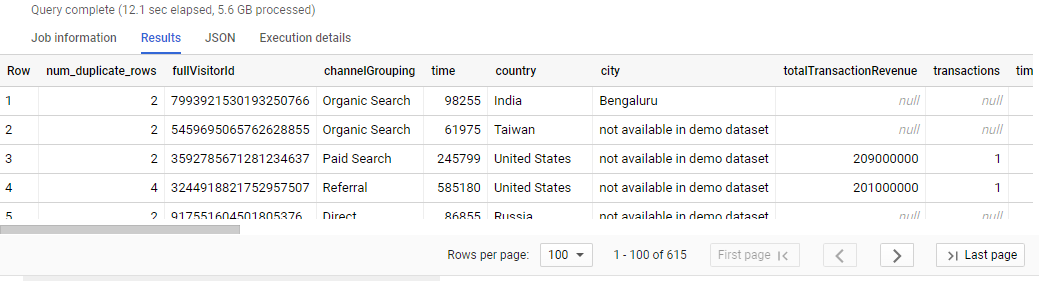

# Analyze the new all_sessions table
In this section you use a deduplicated table called `all_sessions`.

Scenario: Your data analyst team has provided you with this query, and your schema experts have identified the key fields that must be unique for each record per your schema.

Run the query to confirm that no duplicates exist, this time in the all_sessions table:

In [ ]:
#standardSQL
# schema: https://support.google.com/analytics/answer/3437719?hl=en
SELECT
fullVisitorId, # the unique visitor ID
visitId, # a visitor can have multiple visits
date, # session date stored as string YYYYMMDD
time, # time of the individual site hit  (can be 0 to many per visitor session)
v2ProductName, # not unique since a product can have variants like Color
productSKU, # unique for each product
type, # a visitor can visit Pages and/or can trigger Events (even at the same time)
eCommerceAction_type, # maps to ‘add to cart', ‘completed checkout'
eCommerceAction_step,
eCommerceAction_option,
  transactionRevenue, # revenue of the order
  transactionId, # unique identifier for revenue bearing transaction
COUNT(*) as row_count
FROM
`data-to-insights.ecommerce.all_sessions`
GROUP BY 1,2,3 ,4, 5, 6, 7, 8, 9, 10,11,12
HAVING row_count > 1 # find duplicates

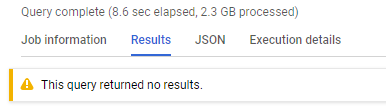

The query returns zero records.

Note: In SQL, you can `GROUP BY` or `ORDER BY` the index of the column like using "GROUP BY 1" instead of "GROUP BY fullVisitorId"

# Write basic SQL on ecommerce data

### 1. Write a query that shows total unique visitors
Your query determines the total views by counting `product_views` and the number of unique visitors by counting `fullVisitorID`.

In [ ]:
#standardSQL
SELECT
  COUNT(*) AS product_views,
  COUNT(DISTINCT fullVisitorId) AS unique_visitors
FROM `data-to-insights.ecommerce.all_sessions`;

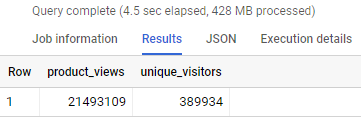

### 2. Now write a query that shows total unique visitors(`fullVisitorID`) by the referring site (`channelGrouping`).

In [ ]:
#standardSQL
SELECT
  COUNT(DISTINCT fullVisitorId) AS unique_visitors,
  channelGrouping
FROM `data-to-insights.ecommerce.all_sessions`
GROUP BY channelGrouping
ORDER BY channelGrouping DESC;

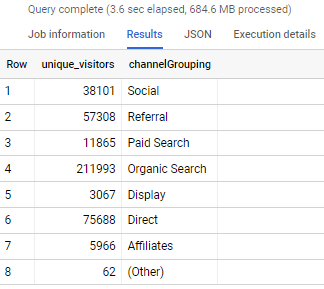

### 3. Write a query to list all the unique product names (`v2ProductName`) alphabetically.

In [ ]:
#standardSQL
SELECT
  (v2ProductName) AS ProductName
FROM `data-to-insights.ecommerce.all_sessions`
GROUP BY ProductName
ORDER BY ProductName

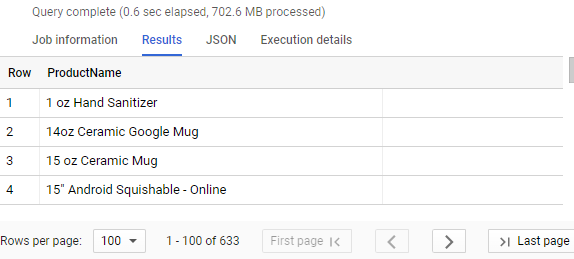

Tip: In SQL, the `ORDER BY` clauses defaults to Ascending (ASC) A-->Z. If you want the reverse, try `ORDER BY` field_name `DESC`

### 4. Write a query to list the five products with the most views (`product_views`) from all visitors (include people who have viewed the same product more than once). Your query counts number of times a product (`v2ProductName`) was viewed (`product_views`), puts the list in descending order, and lists the top 5 entries.

Tip: In Google Analytics, a visitor can "view" a product during the following interaction types: 'page', 'screenview', 'event', 'transaction', 'item', 'social', 'exception', 'timing'. For our purposes, simply filter for only type = 'PAGE'.

In [ ]:
#standardSQL
SELECT
  COUNT(*) AS product_views,
  (v2ProductName) AS ProductName
FROM `data-to-insights.ecommerce.all_sessions`
WHERE type = 'PAGE'
GROUP BY v2ProductName
ORDER BY product_views DESC
LIMIT 5;

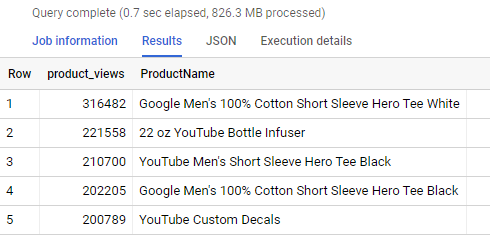

### 5. Bonus: Now refine the query to no longer double-count product views for visitors who have viewed a product many times. Each distinct product view should only count once per visitor.

Tip: You can use the SQL `WITH` clause to help break apart a complex query into multiple steps. Here we first create a query that finds each unique product per visitor and counts them once. Then the second query performs the aggregation across all visitors and products.

In [ ]:
WITH unique_product_views_by_person AS (
-- find each unique product viewed by each visitor
SELECT
 fullVisitorId,
 (v2ProductName) AS ProductName
FROM `data-to-insights.ecommerce.all_sessions`
WHERE type = 'PAGE'
GROUP BY fullVisitorId, v2ProductName )
-- aggregate the top viewed products and sort them
SELECT
  COUNT(*) AS unique_view_count,
  ProductName
FROM unique_product_views_by_person
GROUP BY ProductName
ORDER BY unique_view_count DESC
LIMIT 5

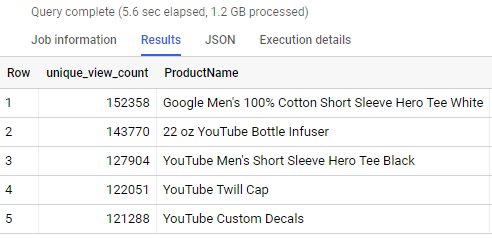

### 6. Next, expand your previous query to include the total number of distinct products ordered and the total number of total units ordered (`productQuantity`).

In [ ]:
#standardSQL
SELECT
  COUNT(*) AS product_views,
  COUNT(productQuantity) AS orders,
  SUM(productQuantity) AS quantity_product_ordered,
  v2ProductName
FROM `data-to-insights.ecommerce.all_sessions`
WHERE type = 'PAGE'
GROUP BY v2ProductName
ORDER BY product_views DESC
LIMIT 5;

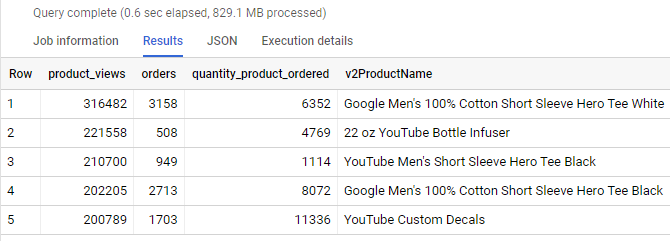

What is the difference between `orders` and `quantity_product_ordered`?

`order` is the number of orders, `quantity_product_ordered` is the number of items ordered.

### 7. Expand the query to include the average amount of product per order (total number of units ordered/total number of orders, or `SUM(productQuantity)/COUNT(productQuantity)`).

In [ ]:
#standardSQL
SELECT
  COUNT(*) AS product_views,
  COUNT(productQuantity) AS orders,
  SUM(productQuantity) AS quantity_product_ordered,
  SUM(productQuantity) / COUNT(productQuantity) AS avg_per_order,
  (v2ProductName) AS ProductName
FROM `data-to-insights.ecommerce.all_sessions`
WHERE type = 'PAGE'
GROUP BY v2ProductName
ORDER BY product_views DESC
LIMIT 5;

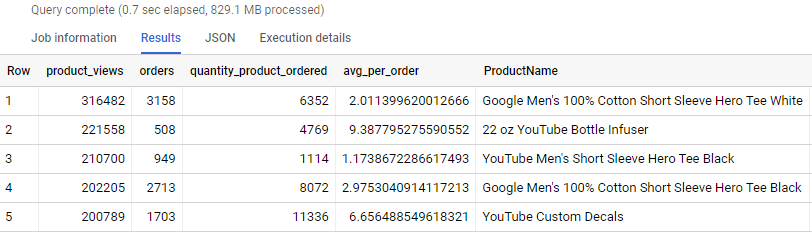